## Prédiction du diabète

Ce projet s'interesse à la prédiction du diabète, à partir d'un dataset récupéré sur le site Kaggle, dont le lien est le suivant: "https://www.kaggle.com/datasets/priyamchoksi/100000-diabetes-clinical-dataset/data"
Le dataset est composé de plusiuers variables dont des données démographiques et cliniques de 100 000 patients.
Plusieurs analyses descriptives ont été réalisées:<br>
Analyse démographique, age des patients, genre des patients, localisation, ...<br>
Analyse de la distribution du diabète entre les différents groupes d'age, la localisation, et l'evolution à travers les années <br>
Analyse de la corrélation entre les differents paramètres cliniques ( BMI, taux HbA1c...) et le diabète <br>
Etude de la relation entre les comorbidités (hypertension, maladies cardiaque) et le diabete <br>
Développement d'un modèle de classification des individus, diabétiques ou non diabétiques

### A- Import des bibliothèques nécessaires au projet:

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import us
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import keras
from keras import layers
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import accuracy_score
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from imblearn.metrics import classification_report_imbalanced

### B- Lecture et analyse du dataset:

In [237]:
df = pd.read_csv("diabetes_dataset.csv")
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


## I. Analyse exploratoire

In [238]:
df.shape
# Le dataset est compsé de 100 000 lignes et 16 colonnes

(100000, 16)

In [239]:
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Ce tableau permet de visualiser par exemple, que l'age moyen des patients est de 41 ans, que les données sont récoltées entre 2015 et 2022, le BMI moyen des patients est 27, le taux de HBA1C est situé entre 5.52% et 9%, le taux de glycémie varie entre 138 et 300 mg/dl.

In [240]:
df.info()
# On constate que la plupart des variables sont numériques à l'exception des variables "gender", "location" et "smoking_history"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [241]:
df['smoking_history'].value_counts()
# La variable smoking_history comporte 6 modalités, et on voit que la modalité No Info est autant représentée que la modalité never

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [242]:
df['gender'].value_counts()
# la catégorie other de la variable gender est non significative, on va la supprimer

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [243]:
df = df.drop(df.loc[df['gender']=='Other'].index, axis = 0)

In [244]:
df['gender'].value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

In [245]:
print(df.duplicated().sum())
# Le dataset contient 14 lignes dupliquées

14


In [246]:
df = df.drop_duplicates()
# Suppression des lignes duppliquées

In [247]:
print(df.duplicated().sum())

0


In [248]:
df.isnull().sum()
# Le dataset ne contient pas de données manquantes

year                    0
gender                  0
age                     0
location                0
race:AfricanAmerican    0
race:Asian              0
race:Caucasian          0
race:Hispanic           0
race:Other              0
hypertension            0
heart_disease           0
smoking_history         0
bmi                     0
hbA1c_level             0
blood_glucose_level     0
diabetes                0
dtype: int64

### Visualisation de la distribution des variables du dataset:

#### 1- Analyse univariée

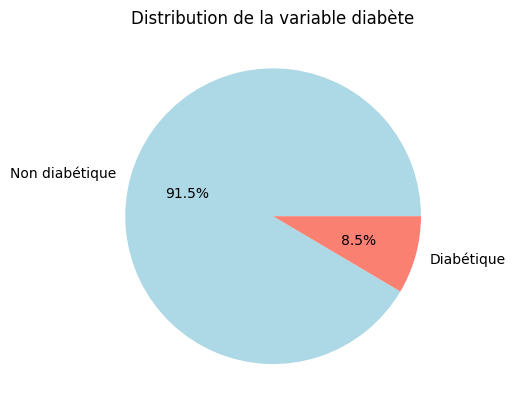

In [249]:
# Visualisation de la distribution de la variable cible "diabète"

# Calcul du nombre de diabétiques et non diabétiques
diabetes_counts = df['diabetes'].value_counts()

# Création du graphique en secteurs
plt.pie(diabetes_counts, labels=['Non diabétique', 'Diabétique'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Distribution de la variable diabète')
plt.show()


# On observe une distribution déséquilibrée de la variable diabète, on constate que la proportion de non diabétiques est beaucoup plus élevée 
# que la proportion de patients diabétiques (91.5% VS 8.5%)  
# Ce constat est à prendre en compte lors de la modélisation

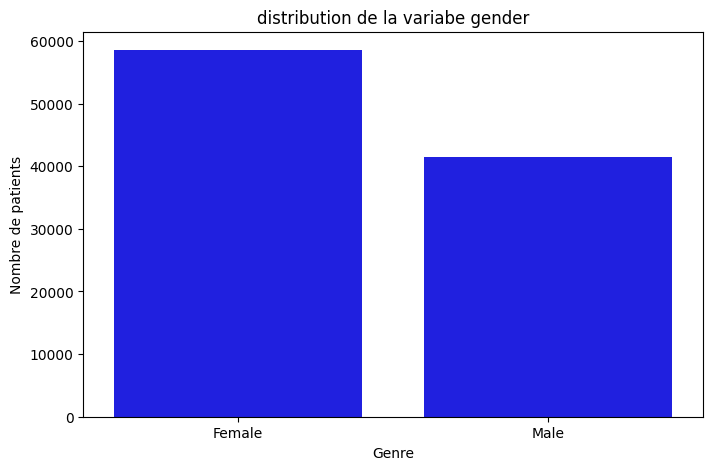

In [250]:
# Visualisation de la distribution de la variable "gender"
plt.figure(figsize=(8, 5))
sns.countplot(x = df['gender'], color = 'blue')
plt.title('distribution de la variabe gender')
plt.xlabel('Genre')
plt.ylabel('Nombre de patients')          
plt.show();

# Les femmes sont plus représentées que les hommes dans ce dataset

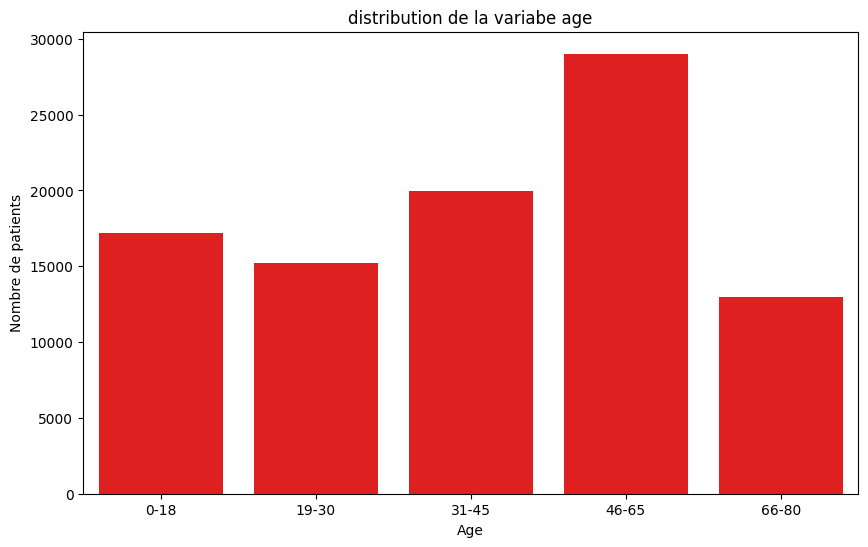

In [251]:
# Distribution de la varible "age":

# Regroupement des patients par tranche d'age afin d'observer la distribution par tranche d'age
bins = [0, 18, 30, 45, 65, 80]
labels = ['0-18', '19-30', '31-45', '46-65', '66-80']
df['tranche_age'] = pd.cut(df['age'], bins = bins, labels = labels, right = False)
plt.figure(figsize=(10, 6))
sns.countplot(x = df['tranche_age'], color = 'red')
plt.title('distribution de la variabe age')
plt.xlabel('Age')
plt.ylabel('Nombre de patients')          
plt.show();
# on constate que la tranche d'age la plus représentée est la 46-65 ans 

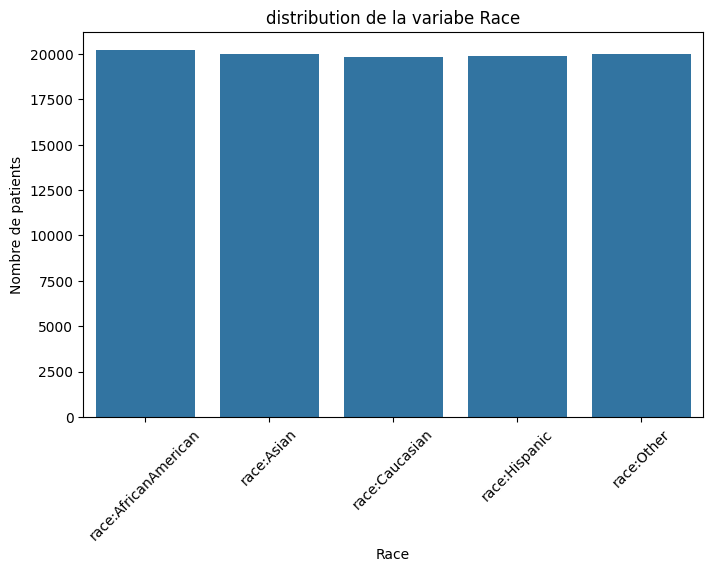

In [252]:
# Visualisation de la distribution de la variable race
# La variable Race a déjà été encodée d'ou la présence de plusieurs colonnes, chacune représente une modalité 
df_race = pd.melt(df[['race:AfricanAmerican','race:Asian','race:Caucasian','race:Hispanic','race:Other']], var_name='Race', value_name='Count')
df_race = df_race[df_race['Count'] == 1]
plt.figure(figsize=(8, 5))
sns.countplot(data = df_race, x = 'Race')
plt.title('distribution de la variabe Race')
plt.xlabel('Race')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=45)
plt.show();

# On constate que les différentes races sont plutot réparties de façon équilibrées

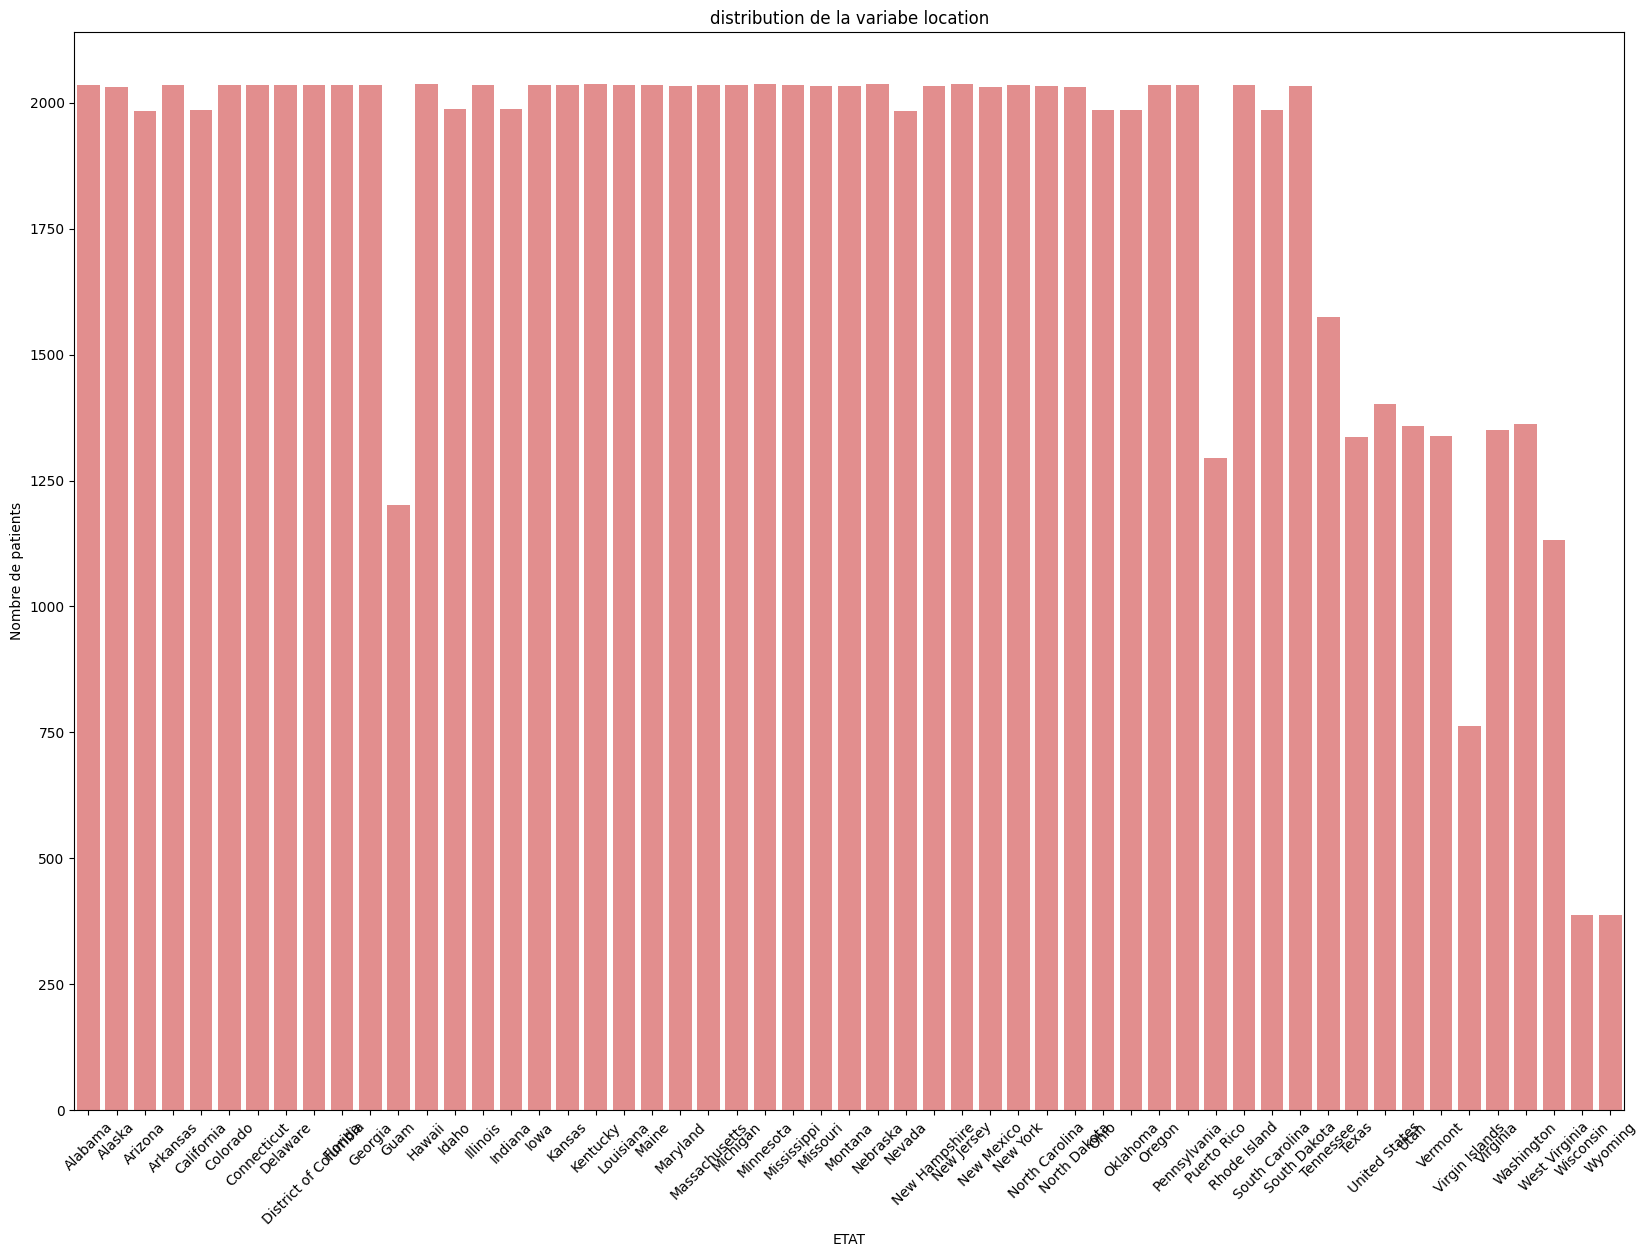

In [253]:
# Distribution de la varible "location":
plt.figure(figsize=(20, 14))
sns.countplot(x = 'location', color = 'lightcoral', data = df)
plt.title('distribution de la variabe location')
plt.xlabel('ETAT')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=45)
plt.show();

# On voit que le nombre de patients est plutot homogène dans la plupart des états à l'exception de quelques uns, exemple du vermont, wisconsin...

#### 2- Analyse multivariée:

<Figure size 1000x400 with 0 Axes>

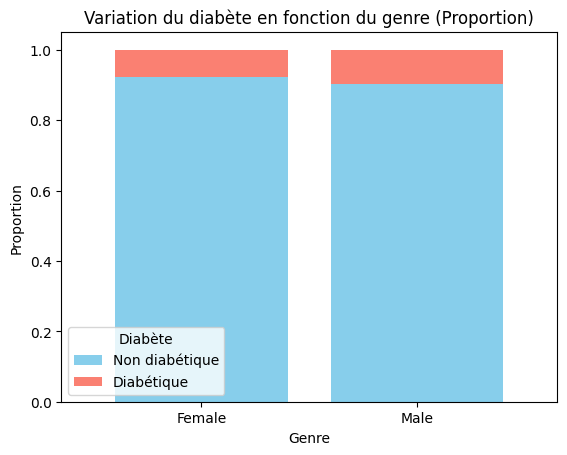

In [254]:
# Analyse de la répartion du diabète en fonction de l'age, du genre et la race
# entre les differents états et en fonction du temps

# Variation du diabète en fonction du genre:

# Calcul des proportions de diabétiques pour chaque genre
df_proportion = df.groupby(['gender', 'diabetes']).size().unstack()
df_proportion = df_proportion.div(df_proportion.sum(axis=1), axis=0)

# Visualisation de la proportion
plt.figure(figsize=(10, 4))
df_proportion.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], width=0.8)
plt.title("Variation du diabète en fonction du genre (Proportion)")
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Diabète', labels=['Non diabétique', 'Diabétique'])
plt.show();

# On observe que la proportion des diabétiques est légérement plus élevées chez les hommes par rapport aux femmes

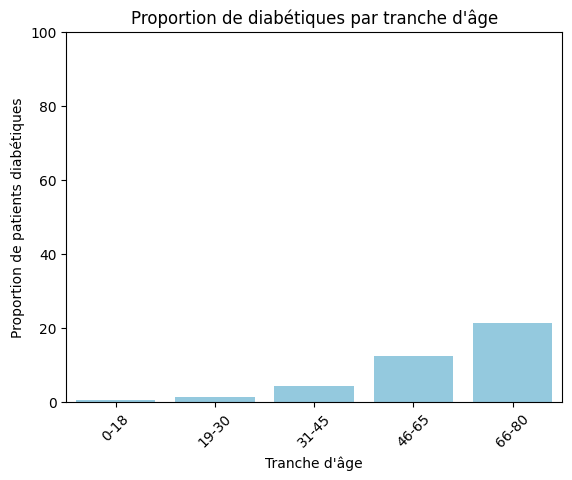

In [255]:
# Variation du diabète en fonction de l'age:

# Calcul du total de patients par tranche d'âge
df_total_age = df.groupby('tranche_age')['diabetes'].count().reset_index()
df_total_age.rename(columns={'diabetes': 'Total de patients'}, inplace=True)

# Calcul du nombre de patients diabétiques par tranche d'âge
df_diabetics_age = df.groupby('tranche_age')['diabetes'].sum().reset_index()
df_diabetics_age.rename(columns={'diabetes': 'Nombre de patients diabétiques'}, inplace=True)

# Fusion des deux DataFrames
df_proportion_age = pd.merge(df_diabetics_age, df_total_age, on='tranche_age')

# Ajout d'une colonne pour la proportion
df_proportion_age['Proportion de diabétiques'] = df_proportion_age['Nombre de patients diabétiques'] / df_proportion_age['Total de patients']*100

# Visualisation de la proportion
sns.barplot(
    data=df_proportion_age, 
    x='tranche_age', 
    y='Proportion de diabétiques', 
    color='skyblue'
)
plt.title('Proportion de diabétiques par tranche d\'âge')
plt.xlabel('Tranche d\'âge')
plt.ylabel('Proportion de patients diabétiques')
plt.ylim(0, 100)  # Les proportions sont entre 0 et 1
plt.xticks(rotation=45)  # Rotation des labels si nécessaire
plt.show()


Ce graphique permet de visualiser l'augmentation de la proportion de diabétiques en fonction de l'age, en effet parmi la tranche d'age 66-80, on distingue la proportion de diabétiques la plus élevée

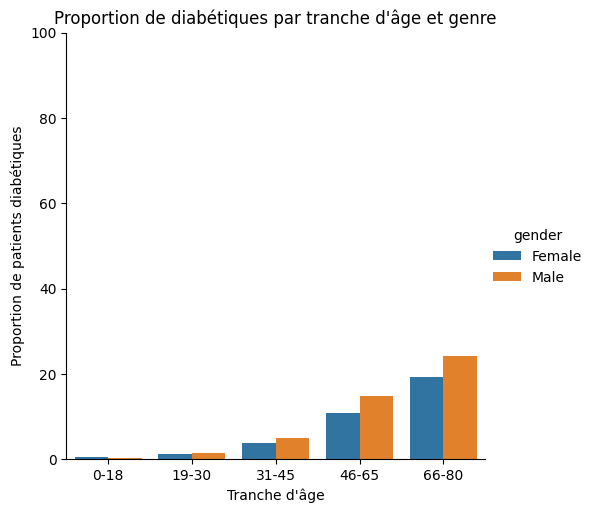

In [256]:
# Representation de la variation du nombre de patients diabétiques par age et genre dans le même graphique:

# Calcul du total de patients par tranche d'âge et genre
df_total = df.groupby(['gender', 'tranche_age'])['diabetes'].count().reset_index()
df_total.rename(columns={'diabetes': 'Total de patients'}, inplace=True)

# Calcul du nombre de patients diabétiques par tranche d'âge et genre
df_diabetics = df.groupby(['gender', 'tranche_age'])['diabetes'].sum().reset_index()
df_diabetics.rename(columns={'diabetes': 'Nombre de patients diabétiques'}, inplace=True)

# Fusion des deux DataFrames
df_proportion = pd.merge(df_diabetics, df_total, on=['gender', 'tranche_age'])

# Ajout d'une colonne pour la proportion
df_proportion['Proportion de diabétiques'] = df_proportion['Nombre de patients diabétiques'] / df_proportion['Total de patients']*100

# Visualisation de la proportion
sns.catplot(
    data=df_proportion, 
    kind='bar', 
    x='tranche_age', 
    y='Proportion de diabétiques', 
    hue='gender'
)
plt.title('Proportion de diabétiques par tranche d\'âge et genre')
plt.xlabel('Tranche d\'âge')
plt.ylabel('Proportion de patients diabétiques')
plt.ylim(0, 100)  
plt.show()

Ce graphique permet de mettre en évidence qu'entre 0 et 18 ans, la proportion de diabétiques est plus importante chez les patients de sexe féminin  par rapport au sexe masculin, il s'inverse dans la tranche d'age 19-30, et on voit qu'en fonction de l'age cet écart tend à se creuser, il est très faible parmi les 19-30 ans puis augmente de plus en plus chez les 31-45, et augmente encore chez les 46-65ans et augmente un peu plus encore chez les 66-80 ans.

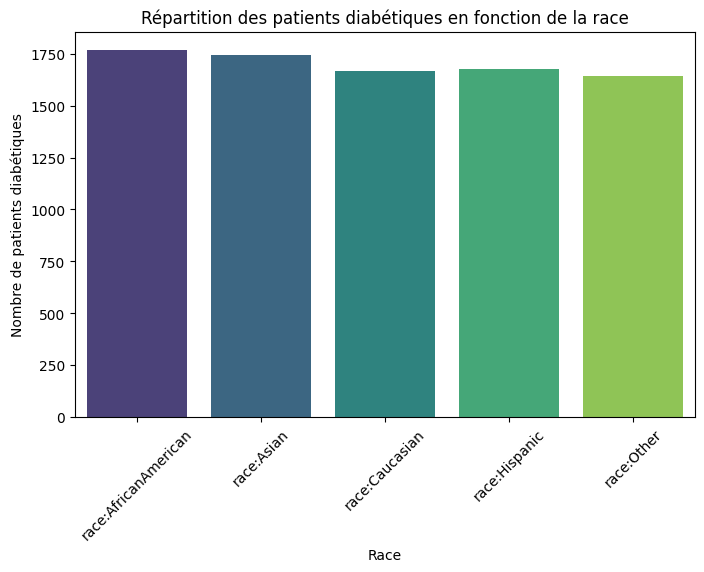

In [257]:
# Visualisation de la distribution du diabètes en fonction des races

# Filtrer uniquement les patients diabétiques
df_diabetic = df[df['diabetes'] == 1]

# Transformation des colonnes encodées 
df_race_diabetic = pd.melt(df_diabetic[['race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 
                                        'race:Hispanic', 'race:Other']], var_name='Race', value_name='Count')

# Garder uniquement les valeurs où la modalité est présente (Count == 1)
df_race_diabetic = df_race_diabetic[df_race_diabetic['Count'] == 1]

# Visualisation
plt.figure(figsize=(8, 5))
sns.countplot(data=df_race_diabetic, x='Race', palette='viridis')
plt.title('Répartition des patients diabétiques en fonction de la race')
plt.xlabel('Race')
plt.ylabel('Nombre de patients diabétiques')
plt.xticks(rotation=45)
plt.show()


On constate que le répartion du nombre de diabétiques est plutot homogène quelque soit la race

   year  patient_total  diabetiques  taux_diabetiques
0  2015           8759          759          8.665373
1  2016           8760          765          8.732877
2  2018           2678          243          9.073936
3  2019          79714         6727          8.438919
4  2020             42            3          7.142857
5  2021              7            1         14.285714
6  2022              8            2         25.000000


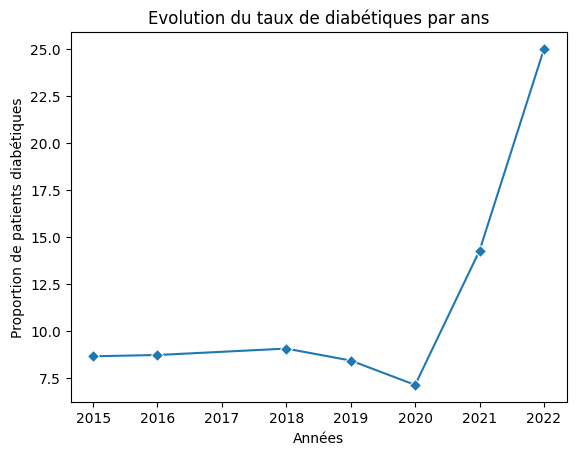

In [258]:
# Etude de l'évolution du taux de diabétiques durant les années:
df_grouped = df.groupby('year')['diabetes'].agg(patient_total = 'count', diabetiques = 'sum').reset_index()
df_grouped['taux_diabetiques'] = (df_grouped['diabetiques']/df_grouped['patient_total']) * 100
print(df_grouped)
# Visualisation des proportions
sns.lineplot(data = df_grouped, x = 'year', y = 'taux_diabetiques', marker="D")
plt.title('Evolution du taux de diabétiques par ans')
plt.xlabel("Années")
plt.ylabel('Proportion de patients diabétiques')
plt.show;

Si on ne disposait pas d'information sur le nombre total de patients, on peut suggérer que:
La proportion de diabétiques est relativement stable et basse entre 2015 et 2019, on constate une baisse entre 2019 et 2020, mais une forte augmentation entre 2020 et 2022. voire une explosion de la proportion entre 2020 et 2022, qui est passée d'environ 5% à 25% en 2 années seulement. 

Le fait d'avoir imprimé les données sur le nombre total de patients et le nombre de diabétiques a permis de mettre en évidence un très faible nombre de patients entre 2020  et 2022 qui rend ce pourcentage non significatif comprés aux poucentages obtenus entre les années 2015 à 2020.

Par contre on peut se poser la question, pourquoi cette forte diminution du nombre de patients total entre 2020 et 2022 et se dire celà est il du à la pandémie du covid-19. 

In [259]:
# Etude la prédominance du diabète dans les différents états des états unis:

# aggregation des données par état et calculer le taux de diabétuqes dans chaque état

df_grouped = df.groupby ('location')['diabetes'].agg(patient_total = 'count', diabetiques = 'sum').reset_index()

# ajout d'une colonne qui représente le taux de diabetiques par état
df_grouped['taux_diabetiques'] = (df_grouped['diabetiques']/ df_grouped['patient_total']) * 100
print(df_grouped)

# Nettoyage des noms des états, suppression des localisations qui ne font pas partis des états unis:

df_grouped = df_grouped[~df_grouped['location'].isin(['Guam', 'Puerto Rico', 'Virgin Islands', 'District of Columbia', 'United States'])]

# Transformation des noms des états en abreviations

df_grouped['location'] = df_grouped['location'].apply(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x)
print(df_grouped['location'].unique())

                location  patient_total  diabetiques  taux_diabetiques
0                Alabama           2035          175          8.599509
1                 Alaska           2032          173          8.513780
2                Arizona           1984          140          7.056452
3               Arkansas           2036          173          8.497053
4             California           1986          161          8.106747
5               Colorado           2035          163          8.009828
6            Connecticut           2035          180          8.845209
7               Delaware           2036          200          9.823183
8   District of Columbia           2036          178          8.742633
9                Florida           2035          176          8.648649
10               Georgia           2035          172          8.452088
11                  Guam           1202          110          9.151414
12                Hawaii           2038          186          9.126595
13    

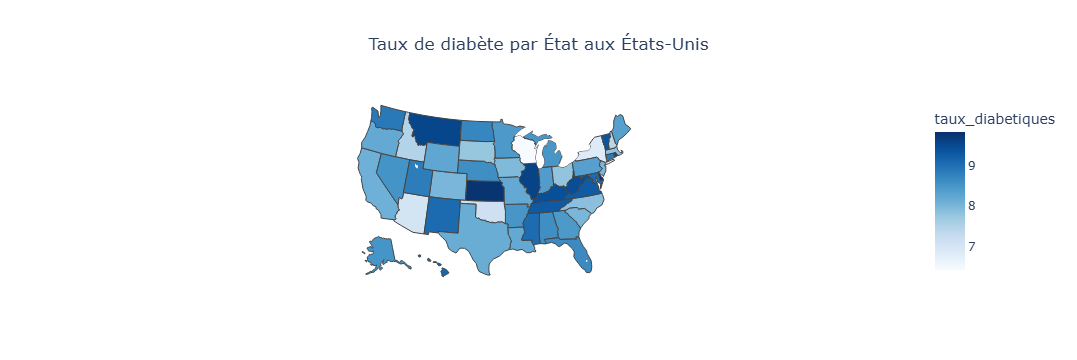

In [260]:
# Visualisation de la répartition des patients diabétiques entre les différents états des états unis

fig = px.choropleth(
    df_grouped,
    locations='location',  # Colonne des États
    locationmode='USA-states',  # Mode des États (abbreviations ou noms complets)
    color='taux_diabetiques',  # Colonne à représenter
    color_continuous_scale='Blues',
    scope='usa',  # Limiter à la carte des USA
    title='Taux de diabète par État aux États-Unis'
)

fig.update_layout(
    geo=dict(showlakes=True, lakecolor='rgb(255, 255, 255)'),
    title_x=0.5
)

fig.show()

# On remarque que la proportion de diabétiques par état varie entre un peu plus de 6% et peu plus de 9%, 
# Ce taux est à son maximum dans les états suivants : Montana, Kansas, Vermont, Virgin Islands, Delaware

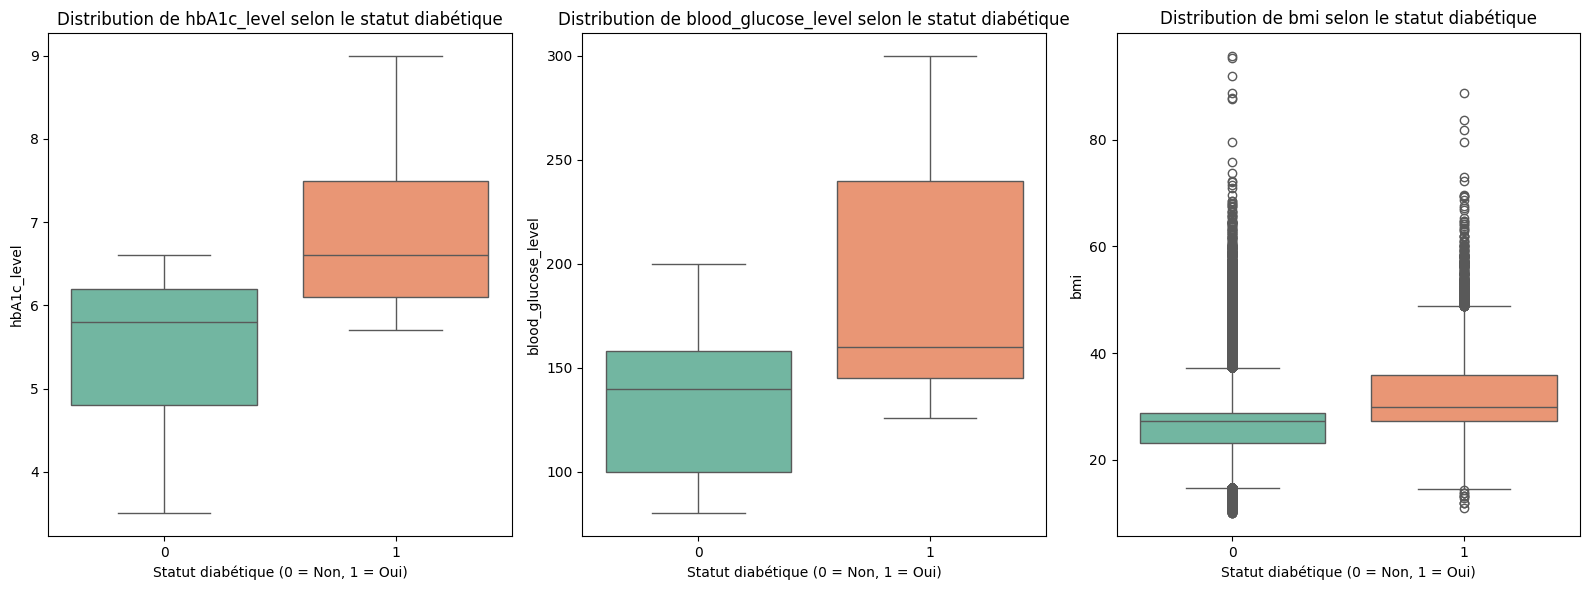

In [261]:
# Visualisation de la distributions des variables continues hbA1c_level, blood_glucose_level, bmi au sein des paients diabétiques et non diabétisues

# Liste des variables continues à visualiser
variables_continues = ['hbA1c_level', 'blood_glucose_level', 'bmi']


plt.figure(figsize=(16, 6))
for i, var in enumerate(variables_continues):
    plt.subplot(1, len(variables_continues), i + 1)  # Subplot pour chaque variable
    sns.boxplot(data=df, x='diabetes', y=var, palette='Set2')  # Boxplot
    plt.title(f'Distribution de {var} selon le statut diabétique')
    plt.xlabel('Statut diabétique (0 = Non, 1 = Oui)')
    plt.ylabel(var)

plt.tight_layout()  
plt.show()

En effet, on observe une différence dans la distribution des variables HBA1C_level et blood_glucose_level entre les patients diabétiques et non diabétiques, avec une moyenne pour le HBA1C inférieur à 6 pour les patients non diabétiques et supérieure à 6 pour les patients diabétiques, de même pour le taux de glycémie, elle est inférieure à 150 mg/dl pour les patients non diabétiques et superieure à 150 mg/dl pour les patients diabétiques.
Par contre concerant le bmi, on n'observe pas une trop grande différence dans sa distribution entre les populations diabétiques et non diabétiques, on observe aussi la présence de beaucoup d'outliers dans les 2 populations, celà dit un bmi superieur à 40 n'est pas impossible mais en effet pas très fréquents.

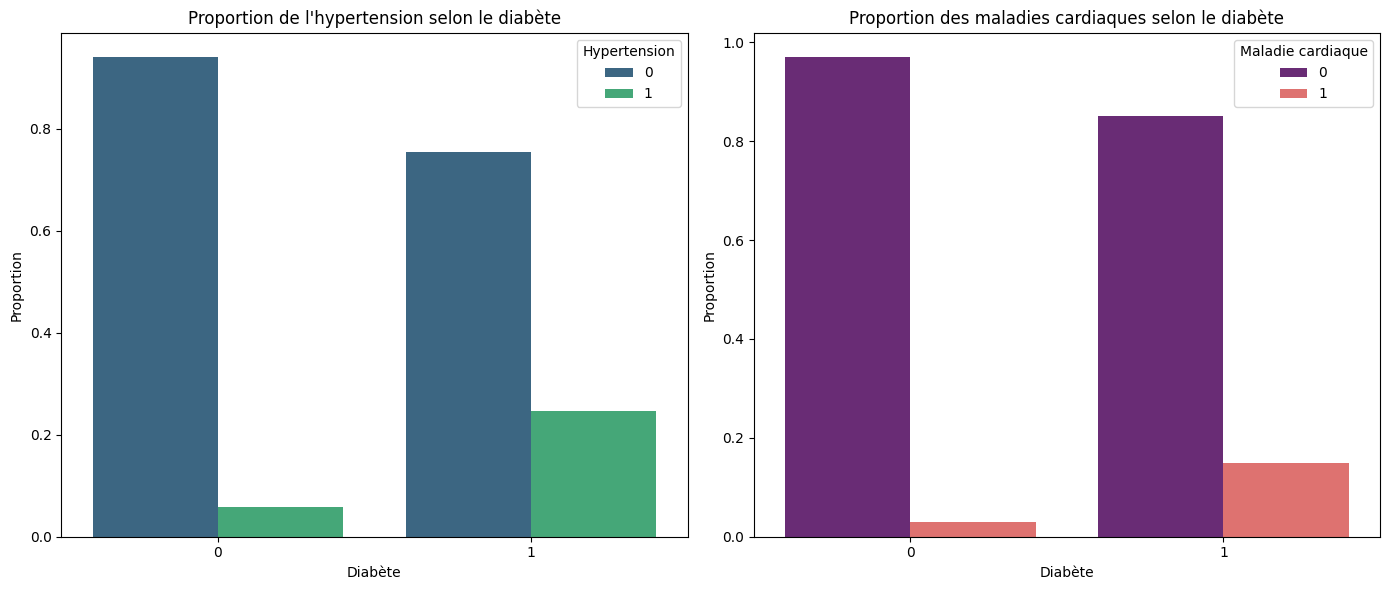

In [262]:
# Représentation des comorbidités (hypertension, maladies cardiaques) dans les populations diabétiques et non diabétiques:

df_hypertension = (
    df.groupby(["diabetes", "hypertension"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .reset_index(level=1, name="proportion")  # Ne réinsère pas 'diabetes'
)

df_heart_disease = (
    df.groupby(["diabetes", "heart_disease"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .reset_index(level=1, name="proportion")  # Ne réinsère pas 'diabetes'
)
# Visualisation des proportions
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Graphique pour hypertension
sns.barplot(
    data=df_hypertension,
    x="diabetes",
    y="proportion",
    hue="hypertension",
    ax=axs[0],
    palette="viridis",
)
axs[0].set_title("Proportion de l'hypertension selon le diabète")
axs[0].set_xlabel("Diabète")
axs[0].set_ylabel("Proportion")
axs[0].legend(title="Hypertension")

# Graphique pour maladies cardiaques
sns.barplot(
    data=df_heart_disease,
    x="diabetes",
    y="proportion",
    hue="heart_disease",
    ax=axs[1],
    palette="magma",
)
axs[1].set_title("Proportion des maladies cardiaques selon le diabète")
axs[1].set_xlabel("Diabète")
axs[1].set_ylabel("Proportion")
axs[1].legend(title="Maladie cardiaque")

plt.tight_layout()
plt.show()

Ce graphique permet de constater une différence de la proportion de patients atteints de maladies cardiaques ou d'hypertension chez les patients diabétiques et les patients non diabétiques, elle est plus importante chez les patients diabétiques. celà en effet suggère que le diabète peut favoriser ces deux comorbidités

In [263]:
# Etude de correlation entre les différentes variables et le diabète
# Encodage des variables catégorielles "gender" et "smoking_histrory" 

df = pd.get_dummies(df, columns=['gender', 'smoking_history'], dtype=int)
df.head()

,year,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,...,diabetes,tranche_age,gender_Female,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,2020,32.0,Alabama,0,0,0,0,1,0,0,...,0,31-45,1,0,0,0,0,0,1,0
1,2015,29.0,Alabama,0,1,0,0,0,0,0,...,0,19-30,1,0,0,0,0,0,1,0
2,2015,18.0,Alabama,0,0,0,0,1,0,0,...,0,19-30,0,1,0,0,0,0,1,0
3,2015,41.0,Alabama,0,0,1,0,0,0,0,...,0,31-45,0,1,0,0,0,0,1,0
4,2016,52.0,Alabama,1,0,0,0,0,0,0,...,0,46-65,1,0,0,0,0,0,1,0


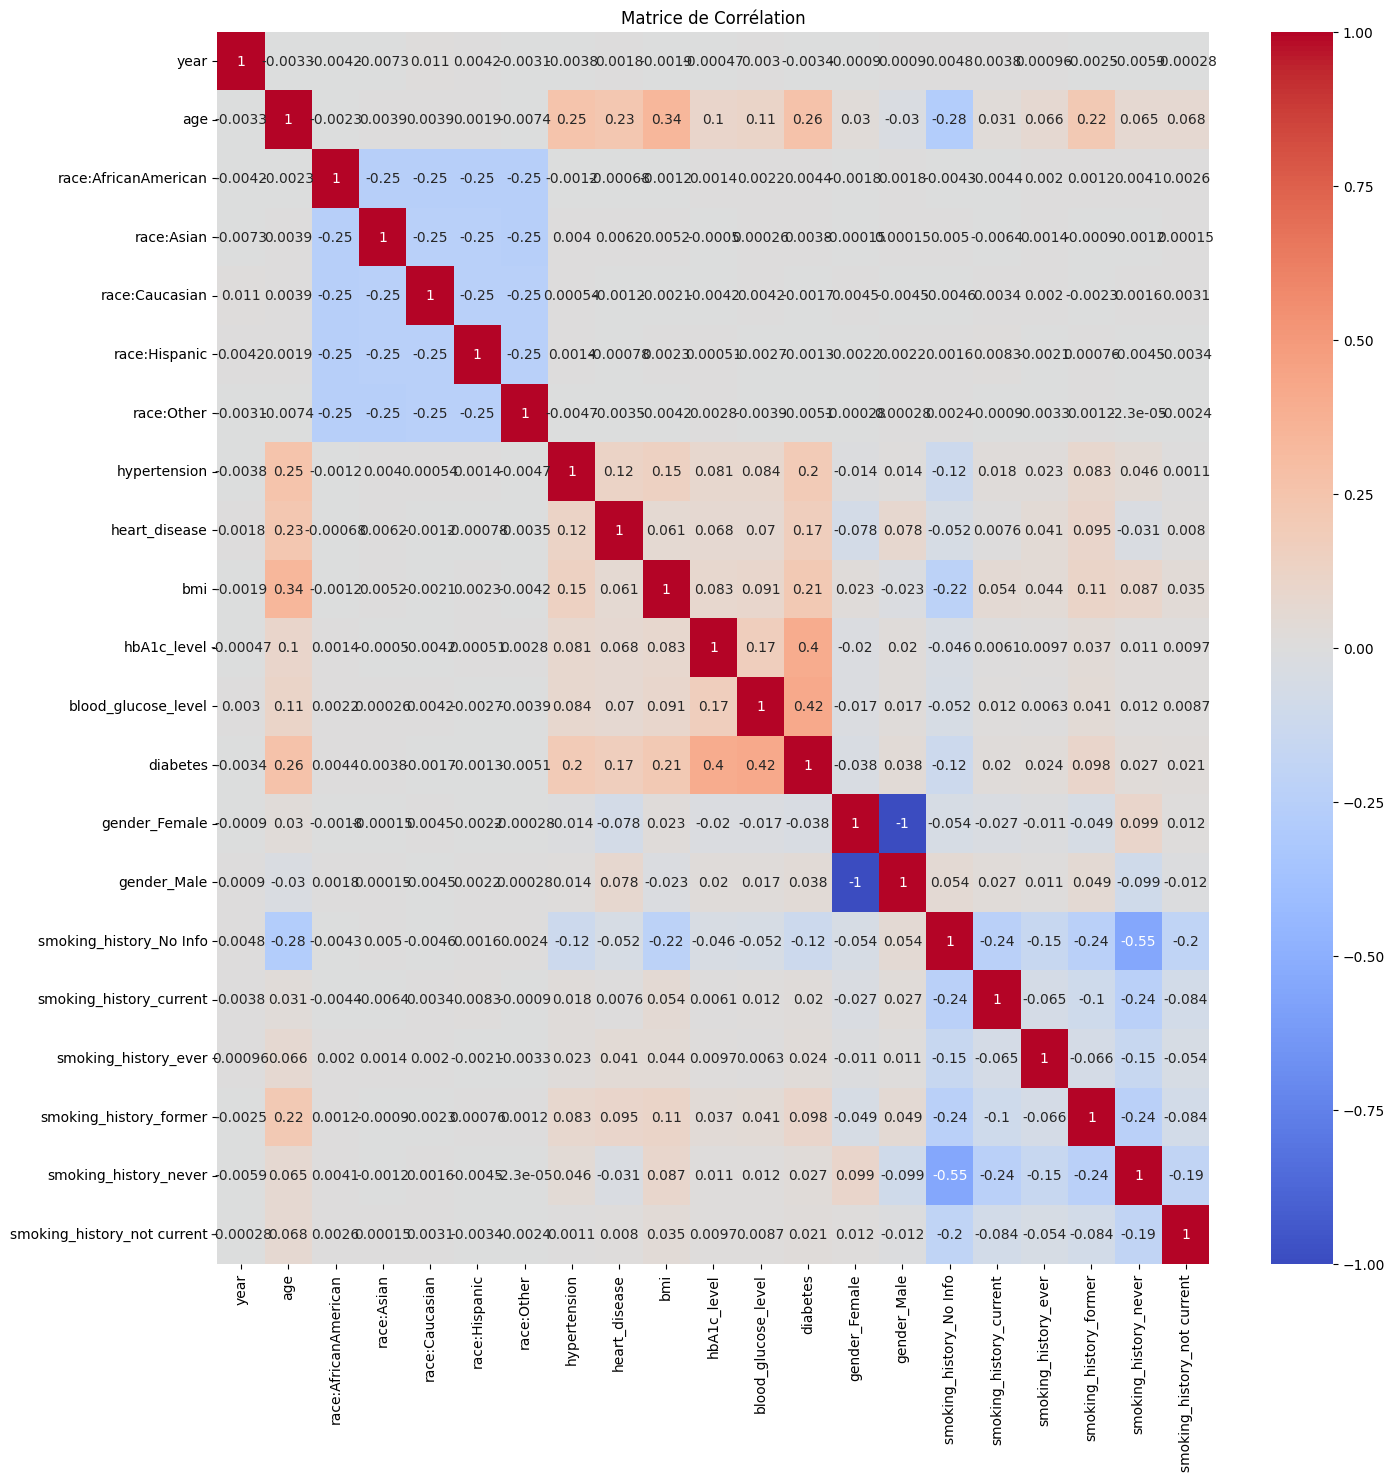

In [264]:
# Suppression de la variable "tranche_age"
df = df.drop(['tranche_age'], axis = 1)

# Sélection des metriques numériques
numeric_df = df.select_dtypes(include=[np.number])

# Visualisation de la correlation
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center = 0)
plt.title('Matrice de Corrélation')
plt.show()  

Cette matrice de correlation, ne met pas en évidence une correlation forte entre une variable donnée et le diabète, cependant, on peut comme même distinguer une faible correlation entre le diabète et l'hypertension, les maladies cardiaques, le BMI et l'age, et une correlation moyenne avec le taux de HBA1C et la glycémie. cette matrice permet de faire une visualisation rapide des relations, mais en effet, ne conviendrait pas vraiment dans notre cas, car notre variable cible n'est pas continue, et la majorité des variables ne sont pas continues non plus, elle sont pour la plupart catégorielles encodées en binaire. si nous voulons vraiment observer les correlations, un test statistique de chi-carré sera plus adapté

## C- Modélisation:

### I. Prerocessing

Avant de procéder à la modélisation, nous allons sélectionner les variables pour l'entrainement du modèle: 
Les variables suivantes:'year','location, ainsi que toues les variables "race", seront supprimées.

In [265]:
x = df.drop(columns = ['year', 'location', 'diabetes', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other'])
y = df['diabetes']

Le choix des modèles: 
Pour ce problème de classification, je vais tester les modèles d'apprentissage supervisé:  regression logistique, SVC, le voisin le plus proche (KNN), l'arbre de décision et la foret aléatoire, et le réseau de neurone profond (DNN).

In [266]:
# Standardisation des données: les variables binaires n'ont pas besoin d'etre standardisées

# Séparation les variables continues et binaires
continuous_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
binary_features = ['hypertension', 'heart_disease', 'gender_Male', 'gender_Female', 'smoking_history_No Info', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']

# Application StandardScaler uniquement sur les variables continues
scaler = StandardScaler()
x_scaled_continuous = scaler.fit_transform(x[continuous_features])

# Réintégration des variables binaires
x_scaled = np.hstack((x_scaled_continuous, x[binary_features]))


In [267]:
# Equilibrage de la variable cible:
# Lors de l'étape de la visualisation, il a été observé un problème de déséquilibre de classe 
#(beaucoup de patients non diabétiques par rapport aux diabétiques)

# Equilibrage des classes: utilisation de la méthode d'Oversampling de smote

sm = SMOTE()
x_sm, y_sm = sm.fit_resample(x_scaled, y)
y_sm.value_counts()

diabetes
0    91468
1    91468
Name: count, dtype: int64

In [268]:
# Séparation des données en groupe test et groupe train
x_sm_train, x_sm_test, y_sm_train, y_sm_test = train_test_split(x_sm, y_sm, test_size = 0.2, random_state = 42)

### II. Modèle de machine learning

In [269]:
# Initialisation des modèles:

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN Neighbors" : KNeighborsClassifier(),
    "SVC": SVC()
}

In [270]:
# Entrainement des modèles:
for name, model in models.items():
    model.fit(x_sm_train, y_sm_train)

In [271]:
# Evaluation des performances de chaque modèle:
for name, model in models.items():
    y_pred = model.predict(x_sm_test)
    accuracy = accuracy_score(y_sm_test, y_pred)
    print(f"score accuracy {name}:", accuracy, "\n")
    print(f"performance pour {name}:")
    print(classification_report(y_sm_test, y_pred), "\n" )

score accuracy Logistic Regression: 0.8868754782988958 

performance pour Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     18303
           1       0.89      0.88      0.89     18285

    accuracy                           0.89     36588
   macro avg       0.89      0.89      0.89     36588
weighted avg       0.89      0.89      0.89     36588
 

score accuracy Decision Tree: 0.9673116868918771 

performance pour Decision Tree:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     18303
           1       0.96      0.97      0.97     18285

    accuracy                           0.97     36588
   macro avg       0.97      0.97      0.97     36588
weighted avg       0.97      0.97      0.97     36588
 

score accuracy Random Forest: 0.9760303924784082 

performance pour Random Forest:
              precision    recall  f1-score   support

           0       0.98   

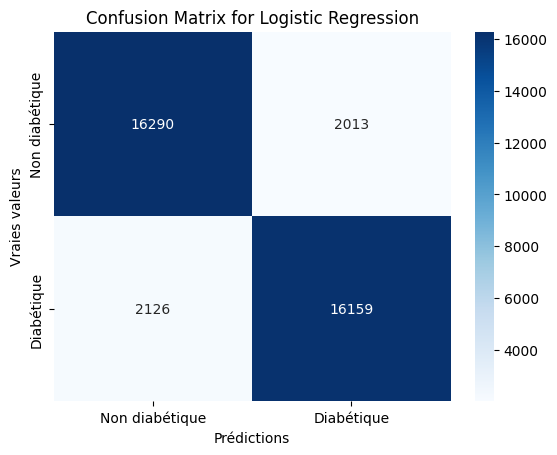

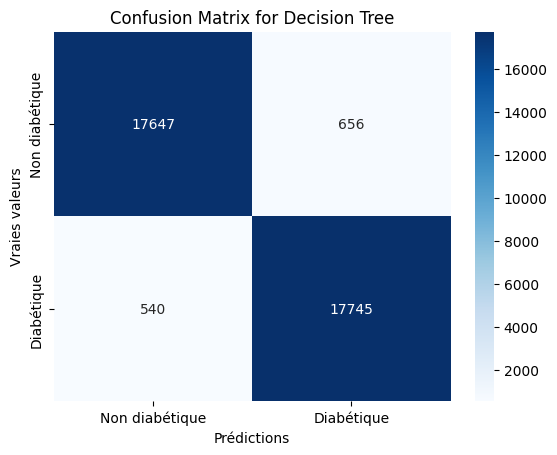

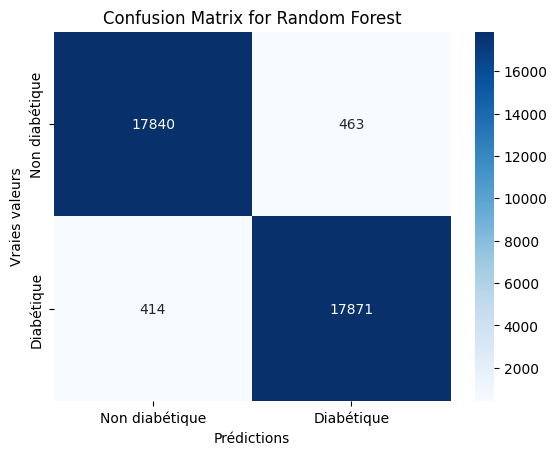

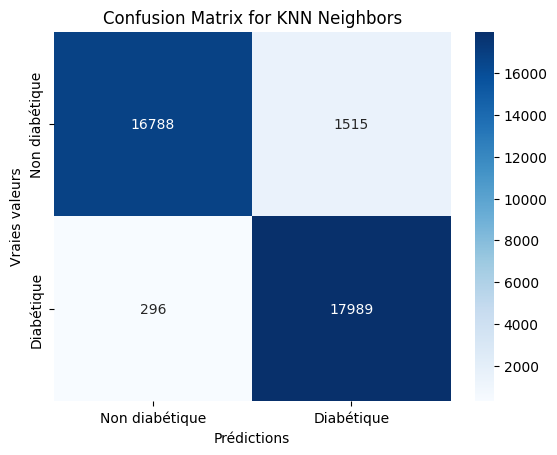

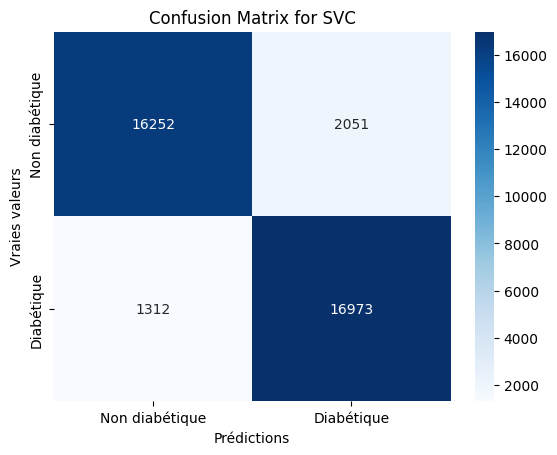

In [272]:
# Visualisation de la matrice de confusion:
for name, model in models.items():
    cm = confusion_matrix(y_sm_test, model.predict(x_sm_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non diabétique', 'Diabétique'], yticklabels=['Non diabétique', 'Diabétique'])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.show()
    

On constate que le modèle qui a présenté les meilleures performances est le modèle random forest, même si le decision tree et le KNN neighbors ont également présenté de bons resultats, à l'inverse, le SVC et logistic regression ont présenté de moins bonnes performances.

### III. Modèle de deep learning

In [273]:
# Création du modèle

model = Sequential([
    Dense(32, activation='relu', input_shape=(14,)),
    Dropout(0.3),  # Dropout après la première couche
    Dense(64, activation='relu'),
    Dropout(0.3),  # Dropout après la deuxième couche
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,193 (172.63 KB)

 Trainable params: 44,193 (172.63 KB)

 Non-trainable params: 0 (0.00 B)

In [274]:
# Création des callbacks
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [275]:
training_history = model.fit(x_sm_train, y_sm_train, epochs=100, batch_size=128, validation_split=0.2, callbacks =[reduce_learning_rate,early_stopping])

Epoch 1/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8507 - loss: 0.3158 - val_accuracy: 0.9001 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 2/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8970 - loss: 0.2139 - val_accuracy: 0.9058 - val_loss: 0.1930 - learning_rate: 0.0010
Epoch 3/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9025 - loss: 0.2024 - val_accuracy: 0.9092 - val_loss: 0.1853 - learning_rate: 0.0010
Epoch 4/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9055 - loss: 0.1940 - val_accuracy: 0.9121 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 5/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9067 - loss: 0.1909 - val_accuracy: 0.9114 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 6/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9082 - loss: 0.1866 - val_accuracy: 0.9127 - val_loss: 0.1772 - learning_rate: 0.0010
Epoch 7/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9090 - loss: 0.

In [276]:
test_pred = model.predict(x_sm_test)

1144/1144 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


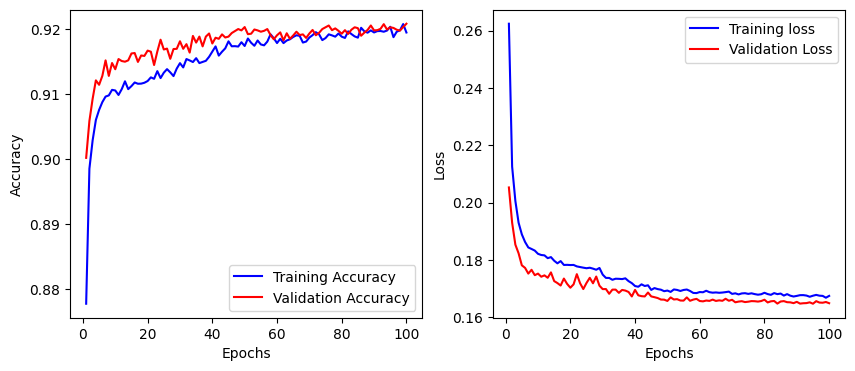

In [277]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 101, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')
plt.plot(np.arange(1 , 101, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')
plt.legend();

plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(1 , 101, 1),
         training_history.history['loss'],
         label = 'Training loss',
         color = 'blue')
plt.plot(np.arange(1 , 101, 1),
         training_history.history['val_loss'], 
         label = 'Validation Loss',
         color = 'red')
plt.legend()

In [278]:
# Calcul de l'accuracy
test_pred_class = (test_pred > 0.5).astype(int).flatten()  # Convertir les probabilités en classes 0 ou 1
accuracy = accuracy_score(y_sm_test, test_pred_class)
print(f"Accuracy du modèle DNN : {accuracy:.4f}", "\n")
print(f" Classification_report_imbalanced pour le modèle DNN:","\n", classification_report_imbalanced(y_sm_test, test_pred_class))

Accuracy du modèle DNN : 0.9190 

 Classification_report_imbalanced pour le modèle DNN: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.90      0.93      0.92      0.92      0.84     18303
          1       0.91      0.93      0.90      0.92      0.92      0.85     18285

avg / total       0.92      0.92      0.92      0.92      0.92      0.84     36588



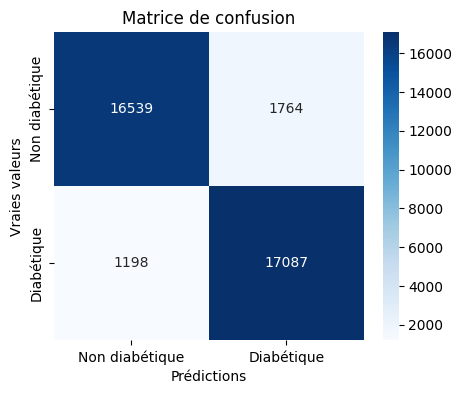

In [279]:
# Génération de la matrice de confusion
cm = confusion_matrix(y_sm_test, test_pred_class)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non diabétique', 'Diabétique'], yticklabels=['Non diabétique', 'Diabétique'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()

Ce modèle de réseau de neurone profond n'a pas permis d'améliorer les performances obsérvées avec les modèles d'apprentissage automatique ex: random forest, bien évidement, plusieurs possibilités d'amélioartion peuvent etre envisagées, par exemple la modification des hyperparamètres, la modification de l'architecture du modèle, ou encore la possibilité d'enrichir le dataset par la création de nouvelles variables, car en effet, ce dataset est très simple, il est constitué seulement de 14 variables après encodage ce qui est faible pour un modèle de reseau de neurone qui préfère des données avec des relations beaucoup plus complèxes

Conclusion:
Les différentes analyses effectuées sur ce dataset, ont permis de faire des observations très interessantes, par exemple l'augementation de la population de diabétiques chez les patients agés entre 65 et 80 ans, une proportion de diabétiques un peu plus élevée chez les hommes que les femmes et ce indépendament de l'age. L'analyse en fonction du genre et de l'age a quand à elle permis de voir qu'au très jeune age, la proportion de diabétiques est plus élévée chez les femmes que chez les hommes, et que celle-ci s'iverse entre 19-35 ans et que cet écart se creuse plus en plus avec l'age.
L'analyse du diabète en fonction de la localisation a également montré que dans certains états, la prédominance de diabétiques est un peu plus élevée par rapport à d'autres, elle est située aux alentours de 9%, exemple du Montana, Kansas, Vermont, Virgin Islands, Delaware.
L'analyse des comorbisités: maladies cardiaques et hypertension, a également permis de montrer qu'en effet, la prédominance de ces pathologies est plus importante chez la population diabétique suggérant comme même un effet du diabète sur ces comorbidités. 

l'évaluation des différents modèles d'apprentisage supervisé, a permis de mettre en évidence l'efficacité du modèle Random forest dans la prédiction du diabète avec un score d'accuracy à 98% comparé aux autres modèles dans cette tache de classification et ou la plupart des variables du dataset sont binaires. 
